# RProp

## Definition: RProp (Resilient Backpropagation)

RProp (Riedmiller & Braun, 1993) is a sign-based optimization method that
decouples the **direction** and the **magnitude** of the update. The direction
is determined only by the sign of the gradient, while the step size for each
parameter is controlled by its own adaptive scalar. The goal is to avoid
problems caused by very large or very small gradient magnitudes and to focus on
whether each parameter should move up or down.

Given the loss $L(\theta)$ and the gradient at step $t$
$$
g_t = \nabla_\theta L(\theta_t),
$$
RProp maintains for each coordinate $i$ a positive step size 
$\Delta_{t} \in \mathbb{R}^{d_{\theta}}_{+}$
and the previous gradient $g_{t-1}$. Define
$$
q_{t} = g_{t-1} * g_{t} \in \mathbb{R}^{d_{\theta}},
$$
where $*$ is the componentwise product. We then update the step size
componentwise as
$$
\Delta_{t} =
\begin{cases}
\min\bigl(\eta_+\, \Delta_{t-1}, \Delta_{\max}\bigr), & q_{t} > 0,\\[6pt]
\max\bigl(\eta_-\, \Delta_{t-1}, \Delta_{\min}\bigr), & q_{t} < 0,\\[6pt]
\Delta_{t-1}, & q_{t} = 0.
\end{cases}
$$
where $\eta_+ > 1$ and $\eta_- \in (0,1)$ are growth and shrink factors, and
$0 < \Delta_{\min} \le \Delta_{\max}$ are bounds.

### Effective gradient rule (this is the actual RProp−/PyTorch behavior)
When the gradient sign flips $(q_t < 0)$, the current gradient in that
coordinate is **ignored**:
$$
g_t^{\text{eff}} =
\begin{cases}
g_t, & q_t \ge 0,\\[4pt]
0,   & q_t < 0.
\end{cases}
$$

The parameter update then becomes
$$
\theta_{t+1}
= \theta_{t}
- \operatorname{sign}\!\bigl(g_t^{\text{eff}}\bigr)\, \Delta_{t}.
$$

**This is the update rule of both the original RProp algorithm and PyTorch’s implementation.**

Thus RProp:
- uses the **sign** of the gradient to determine direction, and  
- uses an adaptive step size $\Delta_{t,i}$, independent of $|g_{t,i}|$, to
  determine the magnitude.

This makes RProp robust to extremely large or small gradient magnitudes and
highly effective when gradients vary erratically in scale.

## Code: RProp

In [37]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from torch.optim.optimizer import Optimizer

from model.mlp import MLP### Training loop

In [38]:
class RProp(Optimizer):
    r"""
    RProp (Resilient Backpropagation), in the style of torch.optim.Rprop.

    Per coordinate i:

        q_{t,i} = g_{t-1,i} * g_{t,i}

        Δ_{t,i} =
            min(η_plus  * Δ_{t-1,i}, Δ_max)   if q_{t,i} > 0  (same sign)
            max(η_minus * Δ_{t-1,i}, Δ_min)   if q_{t,i} < 0  (sign flip)
            Δ_{t-1,i}                         otherwise

        θ_{t+1,i} = θ_{t,i} - sign(g_{t,i}) * Δ_{t,i}

    Here lr is only used to set the initial Δ_0 = lr.
    """

    def __init__(
        self,
        params,
        lr: float = 1e-2,
        etas: tuple[float, float] = (0.5, 1.2),
        step_sizes: tuple[float, float] = (1e-6, 50.0),
    ):
        if lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        eta_minus, eta_plus = etas
        if not (0.0 < eta_minus < 1.0 < eta_plus):
            raise ValueError(f"Invalid etas: {etas}")
        step_min, step_max = step_sizes
        if not (step_min > 0.0 and step_max >= step_min):
            raise ValueError(f"Invalid step_sizes: {step_sizes}")

        defaults = dict(lr=lr, etas=etas, step_sizes=step_sizes)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        """Perform a single RProp update (no closure, returns None)."""
        for group in self.param_groups:
            lr = group["lr"]
            eta_minus, eta_plus = group["etas"]
            step_min, step_max = group["step_sizes"]

            for p in group["params"]:
                grad = p.grad
                if grad is None:
                    continue

                state = self.state[p]

                # Initialize state once
                if len(state) == 0:
                    state["prev_grad"] = torch.zeros_like(p)
                    # step_size_0 = lr (PyTorch uses lr this way)
                    state["step_size"] = torch.full_like(p, lr)

                prev_grad = state["prev_grad"]
                step_size = state["step_size"]

                # q_t = g_{t-1} * g_t, tells us if signs agree
                q = prev_grad * grad

                same_mask = q > 0      # same sign
                flip_mask = q < 0      # sign flip
                # q == 0 -> keep step_size

                # Build multiplicative factor for Δ_t: {η_plus, η_minus, 1}
                factor = torch.ones_like(grad)
                factor[same_mask] = eta_plus
                factor[flip_mask] = eta_minus

                # Update and clamp step sizes
                step_size.mul_(factor)
                step_size.clamp_(step_min, step_max)

                # When sign flips, ignore current gradient for that coordinate
                grad_eff = grad.clone()
                grad_eff[flip_mask] = 0.0

                # RProp update: θ_{t+1} = θ_t − sign(g_eff) * Δ_t
                p.add_(torch.sign(grad_eff) * step_size, alpha=-1.0)

                # Store effective gradient for next step
                prev_grad.copy_(grad_eff)

        return None

### Data

In [39]:
def f(x):
    return 1+2*x**2

N = 20
xs = (4*torch.rand(N)-2).unsqueeze(1)
ys = f(xs) + 0.5*torch.randn(N).unsqueeze(1)

x = torch.linspace(-2,2,100,requires_grad=True)
x_eval = torch.linspace(-2,2,100)
torch.manual_seed(1)

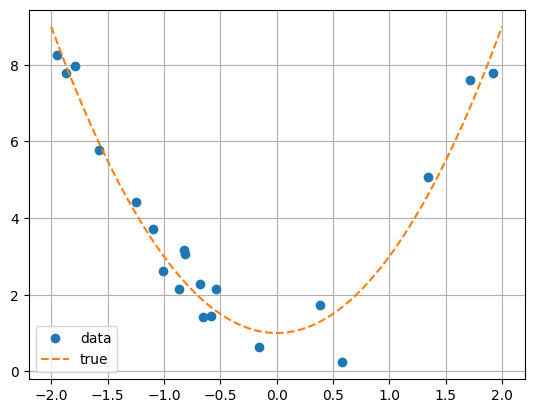

In [40]:
plt.plot(xs.detach().numpy(), ys.detach().numpy(), 'o',label='data')
plt.plot(x.detach().numpy(), f(x).detach().numpy(), '--',label='true')
plt.legend()
plt.grid()
plt.show()


### Training loop

In [41]:
def train(model, opt, loss_fn, data, epochs=20, batch_size=1):
    xs, ys = data
    N = xs.shape[0]
    model.train()
    losses = []
    for epoch in range(epochs):
        perm = torch.randperm(N)  # shuffle for stochasticity each epoch
        for i in range(0, N, batch_size):
            batch_idx = perm[i:i + batch_size]
            x = xs[batch_idx]
            y = ys[batch_idx]
            opt.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
        losses.append(loss.item())
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")   
    return losses

def compare_losses(loss,nn_loss,title):
    plt.plot(nn_loss,linestyle="-",label="nn_loss")
    plt.plot(loss,linestyle="--",label="loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

## Parameters

In [42]:
lr = 0.01
etas=(0.5, 1.2)
step_sizes=(1e-6, 50.0)

loss_fn = nn.MSELoss()  

### pytorch

In [43]:
torch.manual_seed(1)
model = MLP(input_dim=1,output_dim=1,hidden_dims=[512,512,512],activation=nn.Tanh())
opt = torch.optim.Rprop(model.parameters(),
        lr=lr,
        etas=etas,
        step_sizes=step_sizes
)

nn_loss = train(model,opt,loss_fn,(xs,ys),epochs=100,batch_size=N)

Epoch 1/100, Loss: 22.2998
Epoch 2/100, Loss: 13.4778
Epoch 3/100, Loss: 113.9295
Epoch 4/100, Loss: 8.8890
Epoch 5/100, Loss: 31.0151
Epoch 6/100, Loss: 14.7699
Epoch 7/100, Loss: 13.3630
Epoch 8/100, Loss: 4.2681
Epoch 9/100, Loss: 5.3349
Epoch 10/100, Loss: 4.1125
Epoch 11/100, Loss: 3.4452
Epoch 12/100, Loss: 1.6653
Epoch 13/100, Loss: 2.0299
Epoch 14/100, Loss: 1.8223
Epoch 15/100, Loss: 1.0023
Epoch 16/100, Loss: 1.0790
Epoch 17/100, Loss: 0.9511
Epoch 18/100, Loss: 0.8147
Epoch 19/100, Loss: 0.8267
Epoch 20/100, Loss: 0.7478
Epoch 21/100, Loss: 0.6962
Epoch 22/100, Loss: 0.6496
Epoch 23/100, Loss: 0.6033
Epoch 24/100, Loss: 0.5653
Epoch 25/100, Loss: 0.5306
Epoch 26/100, Loss: 0.4990
Epoch 27/100, Loss: 0.4675
Epoch 28/100, Loss: 0.4325
Epoch 29/100, Loss: 0.4040
Epoch 30/100, Loss: 0.3822
Epoch 31/100, Loss: 0.3503
Epoch 32/100, Loss: 0.3216
Epoch 33/100, Loss: 0.2948
Epoch 34/100, Loss: 0.2670
Epoch 35/100, Loss: 0.2439
Epoch 36/100, Loss: 0.2231
Epoch 37/100, Loss: 0.2050
Epo

### Custom

Epoch 1/100, Loss: 22.2998
Epoch 2/100, Loss: 13.4778
Epoch 3/100, Loss: 113.9295
Epoch 4/100, Loss: 8.8890
Epoch 5/100, Loss: 31.0151
Epoch 6/100, Loss: 14.7699
Epoch 7/100, Loss: 13.3630
Epoch 8/100, Loss: 4.2681
Epoch 9/100, Loss: 5.3349
Epoch 10/100, Loss: 4.1125
Epoch 11/100, Loss: 3.4452
Epoch 12/100, Loss: 1.6653
Epoch 13/100, Loss: 2.0299
Epoch 14/100, Loss: 1.8223
Epoch 15/100, Loss: 1.0023
Epoch 16/100, Loss: 1.0790
Epoch 17/100, Loss: 0.9511
Epoch 18/100, Loss: 0.8147
Epoch 19/100, Loss: 0.8267
Epoch 20/100, Loss: 0.7478
Epoch 21/100, Loss: 0.6962
Epoch 22/100, Loss: 0.6496
Epoch 23/100, Loss: 0.6033
Epoch 24/100, Loss: 0.5653
Epoch 25/100, Loss: 0.5306
Epoch 26/100, Loss: 0.4990
Epoch 27/100, Loss: 0.4675
Epoch 28/100, Loss: 0.4325
Epoch 29/100, Loss: 0.4040
Epoch 30/100, Loss: 0.3822
Epoch 31/100, Loss: 0.3503
Epoch 32/100, Loss: 0.3216
Epoch 33/100, Loss: 0.2948
Epoch 34/100, Loss: 0.2670
Epoch 35/100, Loss: 0.2439
Epoch 36/100, Loss: 0.2231
Epoch 37/100, Loss: 0.2050
Epo

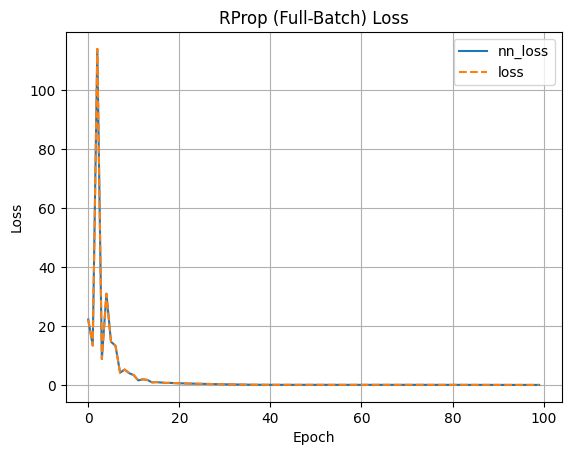

In [44]:
torch.manual_seed(1)
model = MLP(input_dim=1,output_dim=1,hidden_dims=[512,512,512],activation=nn.Tanh())
opt = RProp(model.parameters(),
        lr=lr,
        etas=etas,
        step_sizes=step_sizes
)

loss = train(model,opt,loss_fn,(xs,ys),epochs=100,batch_size=N)
compare_losses(loss,nn_loss,"RProp (Full-Batch) Loss")

# Evaluation

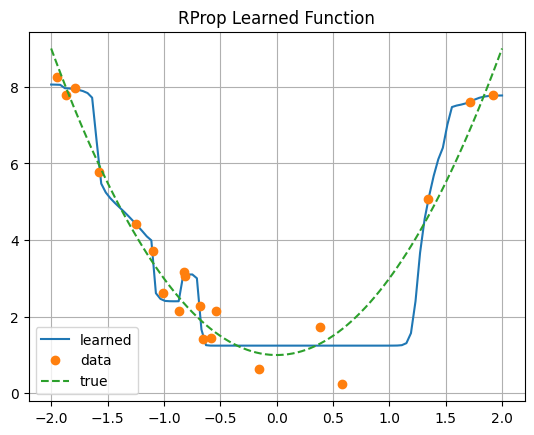

In [45]:
plt.plot(x_eval,model(x_eval[:,None]).squeeze().detach().numpy(), '-',label='learned')
plt.plot(xs.detach().numpy(), ys.detach().numpy(), 'o',label='data')
plt.plot(x_eval,f(x_eval), '--',label='true')
plt.title("RProp Learned Function")
plt.legend()
plt.grid()
plt.show()